## Correlational Analysis
Load the data

In [1]:
fig_path = 'figures/demand/'

In [19]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'external_data/demand/'
files = os.listdir(file_path)

df = pd.read_csv(file_path + files[0])
df = df[:-int(len(df) * 0.4)]
df

,datetime,actual,met,forecast,price,year,month,day,hour,period,...,cloudcover,dewPointC,uvIndex,feelsLikeC,north,south,east,west,central,aggregatePSI
0,2016-01-01 00:00:00,4939.791635,4801.7,4850.6,49.45,2016,1,1,0,Night,...,88.0,23.0,1.0,29.0,35.0,39.0,38.0,40.0,41.0,38.6
1,2016-01-01 01:00:00,4837.297700,4701.3,4685.3,43.23,2016,1,1,1,Night,...,83.0,23.0,1.0,29.0,34.0,39.0,35.0,39.0,40.0,37.4
2,2016-01-01 02:00:00,4751.866150,4619.6,4558.3,43.23,2016,1,1,2,Night,...,86.0,23.0,1.0,29.0,34.0,38.0,34.0,37.0,39.0,36.4
3,2016-01-01 03:00:00,4617.058405,4480.6,4486.8,43.15,2016,1,1,3,Night,...,87.0,23.0,1.0,29.0,34.0,38.0,35.0,36.0,38.0,36.2
4,2016-01-01 04:00:00,4487.779534,4352.4,4411.0,42.08,2016,1,1,4,Night,...,82.0,23.0,1.0,29.0,33.0,37.0,36.0,35.0,38.0,35.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36817,2020-03-14 01:00:00,5828.718881,5697.6,5735.8,59.83,2020,3,14,1,Night,...,33.0,24.0,1.0,32.0,31.0,42.0,43.0,41.0,48.0,41.0
36818,2020-03-14 02:00:00,5656.576710,5529.3,5519.9,58.98,2020,3,14,2,Night,...,43.0,24.0,1.0,31.0,30.0,42.0,41.0,41.0,49.0,40.6
36819,2020-03-14 03:00:00,5514.579660,5390.9,5397.8,58.34,2020,3,14,3,Night,...,54.0,25.0,1.0,31.0,29.0,42.0,42.0,41.0,49.0,40.6
36820,2020-03-14 04:00:00,5444.025754,5319.1,5306.7,58.00,2020,3,14,4,Night,...,58.0,24.0,1.0,31.0,29.0,39.0,40.0,40.0,50.0,39.6


In [20]:
# encode text features to numerical
df['period'] = pd.Categorical(df['period']).codes
df['day_of_week'] = pd.Categorical(df['day_of_week']).codes
df['is_weekend'] = pd.Categorical(df['is_weekend']).codes
df['weatherDesc'] = pd.Categorical(df['weatherDesc']).codes

Testing the function

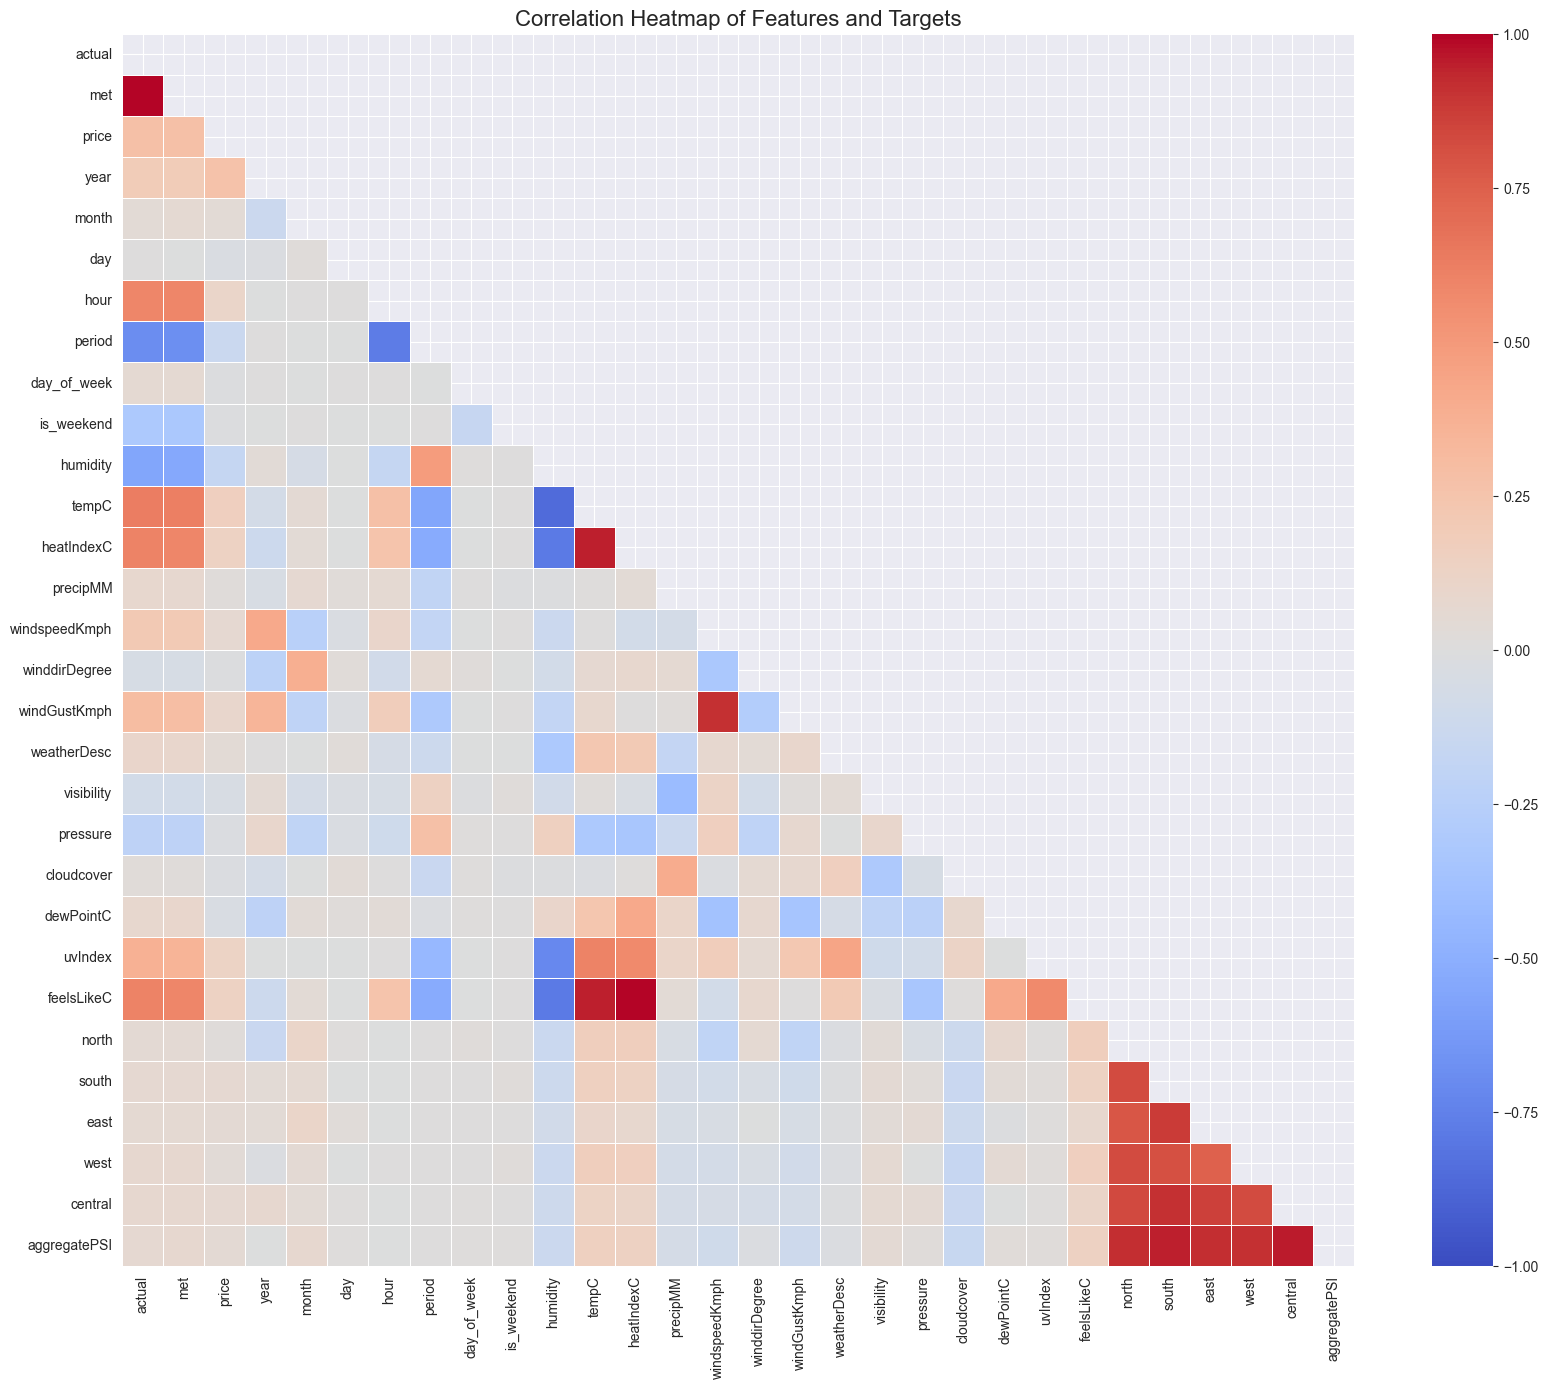

In [21]:
data = df.drop(columns=['datetime', 'forecast'])

corr_matrix = data.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
plt.title('Correlation Heatmap of Features and Targets', fontsize=16)

plt.show()

In [22]:
corr_matrix.loc['feelsLikeC', 'heatIndexC']

np.float64(1.0)

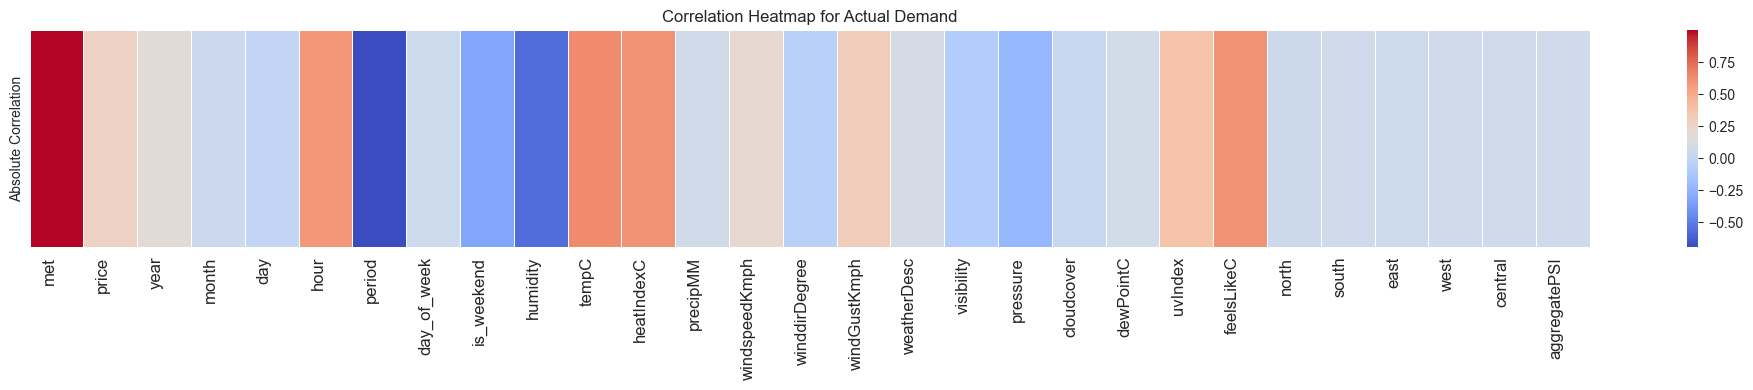

In [23]:
temp = corr_matrix.drop(columns=['actual'])

fig = plt.figure(figsize=(20, 4))

sns.heatmap(pd.DataFrame(temp.iloc[[0]]), cmap='coolwarm', linewidths=.5)
plt.title(f'Correlation Heatmap for Actual Demand')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks([])

plt.tight_layout()
plt.show()
fig.savefig(fig_path + 'correlation_heatmap.png', bbox_inches='tight')

Keep features until humidity, where we observe a visible drop

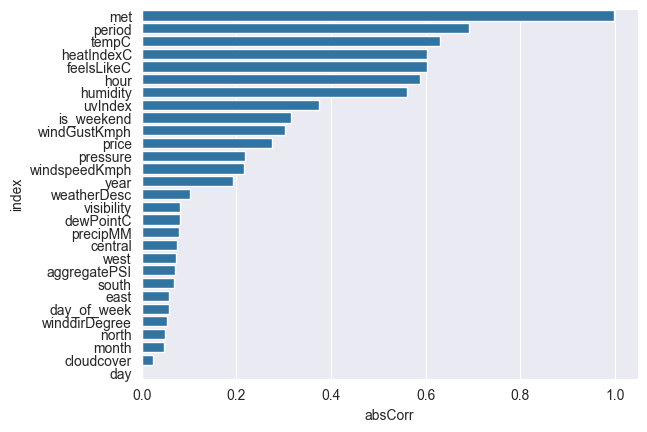

met, period, tempC, heatIndexC, feelsLikeC, hour, humidity, uvIndex, is_weekend, windGustKmph, price, pressure, windspeedKmph, year, weatherDesc, visibility, dewPointC, precipMM, central, west, aggregatePSI, south, east, day_of_week, winddirDegree, north, month, cloudcover, day


In [24]:
corr_with_actual = corr_matrix.iloc[0, 1:].reset_index()
corr_with_actual['absCorr'] = corr_with_actual['actual'].abs()
corr_with_actual.sort_values(by='absCorr', ascending=False, inplace=True)
sns.barplot(corr_with_actual, x='absCorr', y='index')
plt.show()

print(', '.join(corr_with_actual['index'].tolist()))

## Time-based correlational analysis
We need to perform time-based correlational analysis as well. Split the timeseries by years and check which is more valuable in each particular year. 

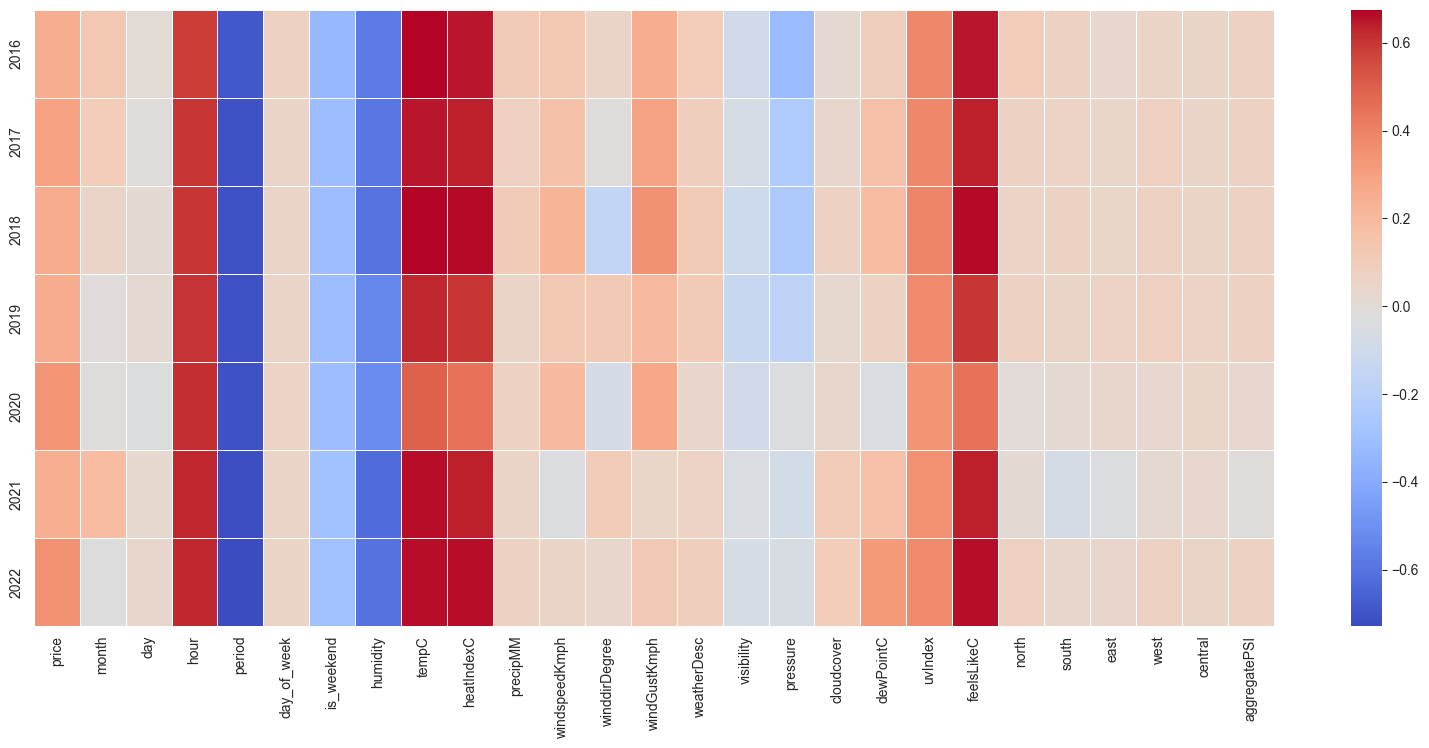

In [131]:
year_corr = []
for year, group in data.groupby('year'):
    temp = group.corr().iloc[0, 3:]
    year_corr.append(temp)
    
year_corr_df = pd.DataFrame(year_corr)
year_corr_df.index = data['year'].unique()
year_corr_df.drop(columns=['year'], inplace=True)
year_corr_df.dropna(inplace=True)

fig = plt.figure(figsize=(20, 8))
sns.heatmap(pd.DataFrame(year_corr_df), cmap='coolwarm', linewidths=.5)
fig.savefig(fig_path + 'correlation_heatmap_by_year.png', bbox_inches='tight')

By month

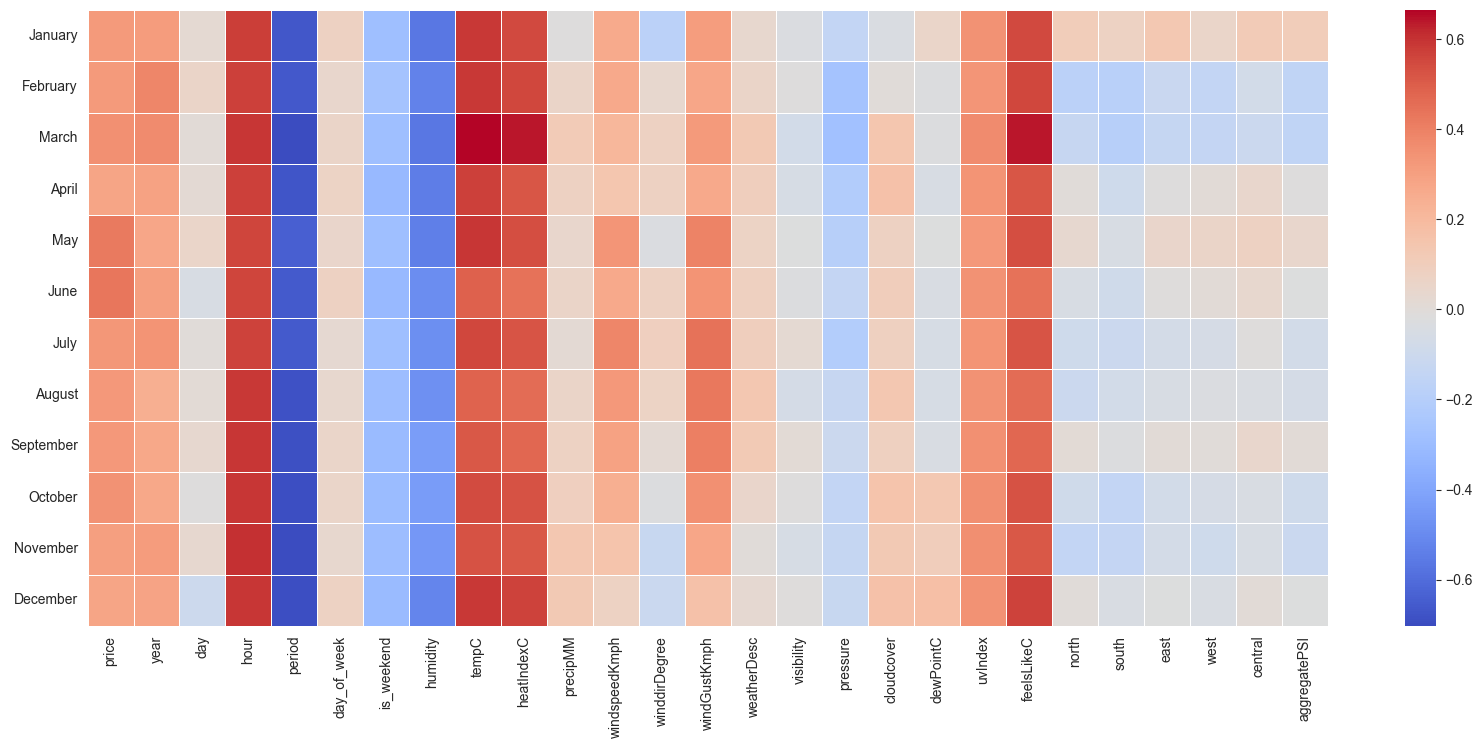

In [132]:
import calendar

month_corr = []
for month, group in data.groupby('month'):
    temp = group.corr().iloc[0, 3:]
    month_corr.append(temp)
    
month_corr_df = pd.DataFrame(month_corr)
month_corr_df.index = list(calendar.month_name)[1:]
month_corr_df.drop(columns=['month'], inplace=True)
month_corr_df.dropna(inplace=True)

fig = plt.figure(figsize=(20, 8))
sns.heatmap(pd.DataFrame(month_corr_df), cmap='coolwarm', linewidths=.5)
fig.savefig(fig_path + 'correlation_heatmap_by_month.png', bbox_inches='tight')

By day

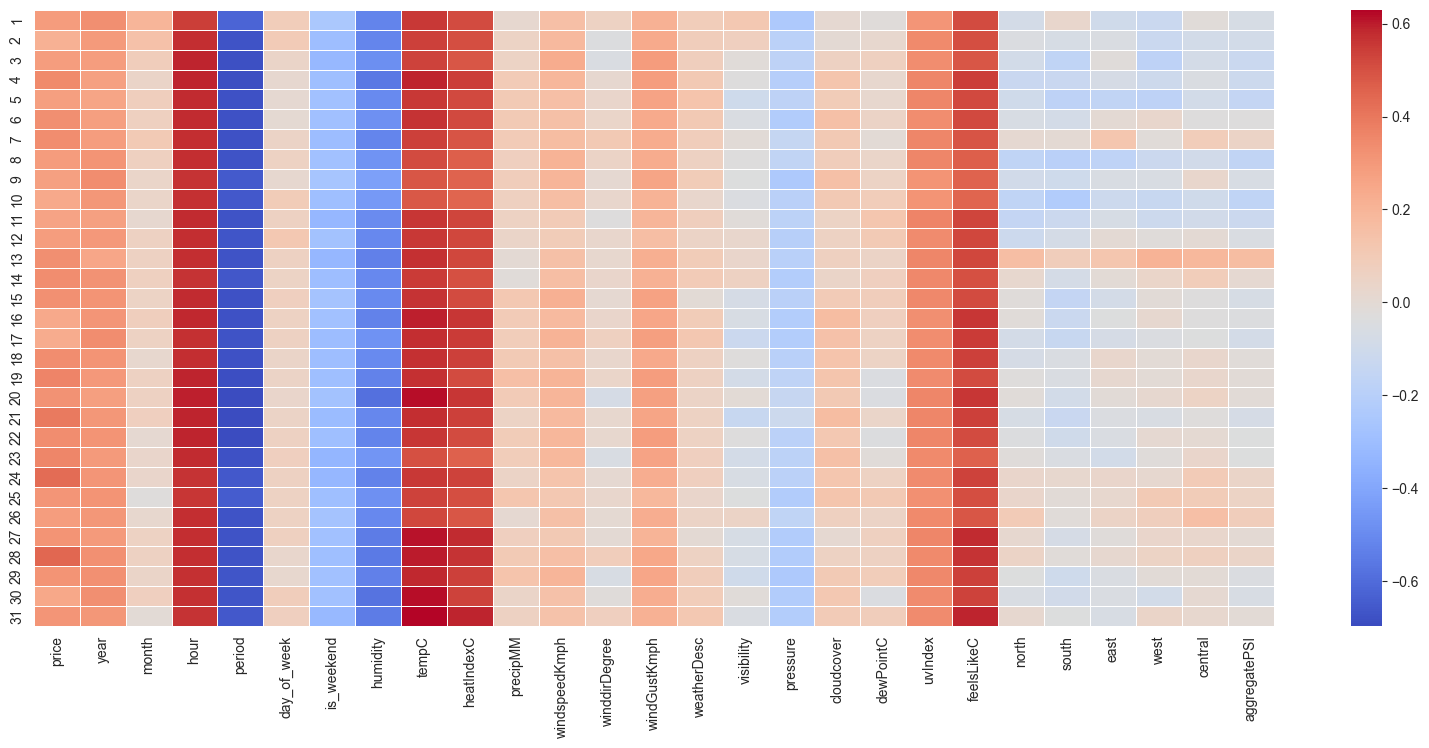

In [133]:
day_corr = []
for day, group in data.groupby('day'):
    temp = group.corr().iloc[0, 3:]
    day_corr.append(temp)
    
day_corr_df = pd.DataFrame(day_corr)
day_corr_df.index = df['day'].unique()
day_corr_df.drop(columns=['day'], inplace=True)
day_corr_df.dropna(inplace=True)

fig = plt.figure(figsize=(20, 8))
sns.heatmap(pd.DataFrame(day_corr_df), cmap='coolwarm', linewidths=.5)
fig.savefig(fig_path + 'correlation_heatmap_by_day.png', bbox_inches='tight')

 By hour

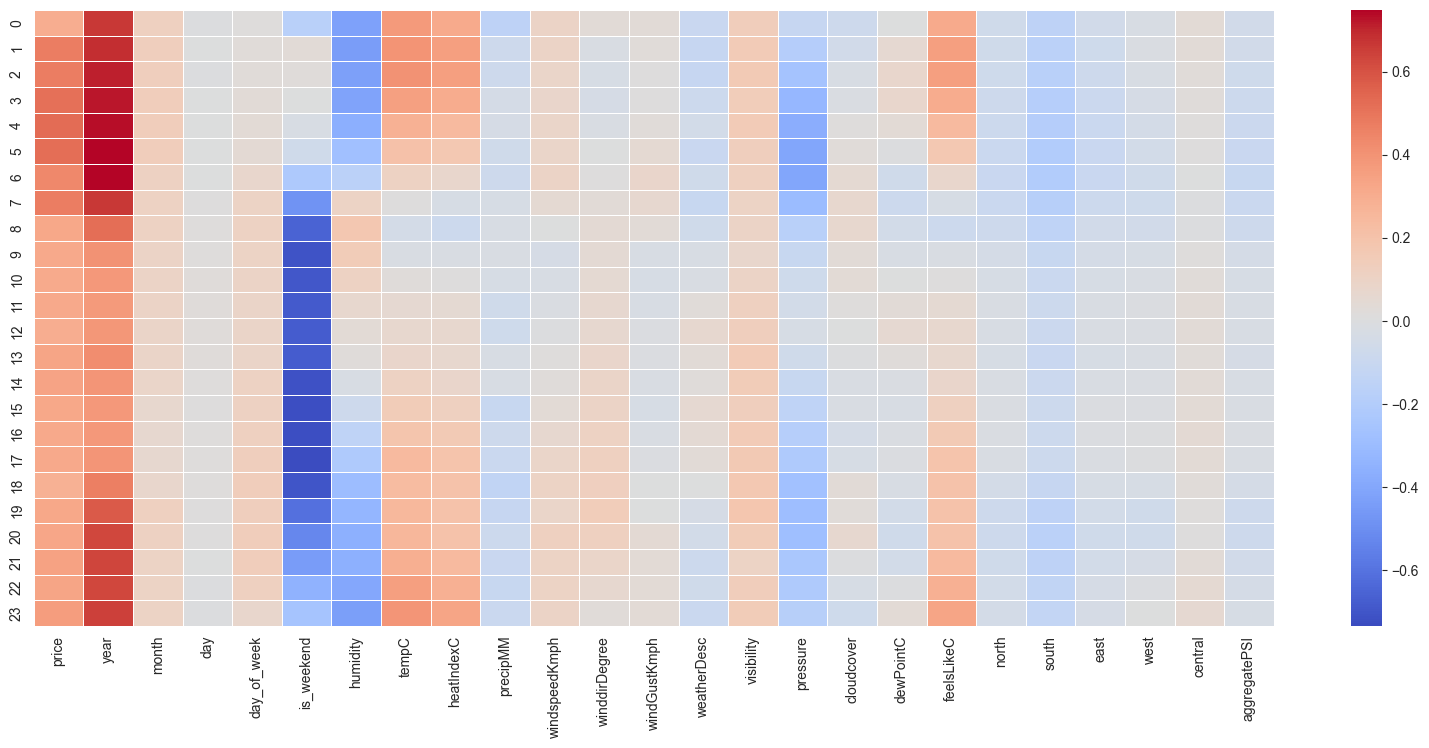

In [134]:
hour_corr = []
for hour, group in data.groupby('hour'):
    temp = group.corr().iloc[0, 3:]
    hour_corr.append(temp)
    
hour_corr_df = pd.DataFrame(hour_corr)
hour_corr_df.index = df['hour'].unique()
hour_corr_df.drop(columns=['hour', 'period', 'uvIndex'], inplace=True)
hour_corr_df.dropna(inplace=True)

fig = plt.figure(figsize=(20, 8))
sns.heatmap(pd.DataFrame(hour_corr_df), cmap='coolwarm', linewidths=.5)
fig.savefig(fig_path + 'correlation_heatmap_by_hour.png', bbox_inches='tight')

## Lag-based relational analysis

In [120]:
import matplotlib.pyplot as plt

time_lags = range(-356, 356)

def calculate_lag_correlation(series1, series2, lag_, corr_type='pearson'):
    if lag_ > 0:
        return series1.corr(series2.shift(lag_), method=corr_type)
    elif lag_ < 0:
        return series1.shift(-lag_).corr(series2, method=corr_type)
    else:
        return series1.corr(series2, method=corr_type)

def plot_lag_correlation(avg_corr_, var1, var2, lags, fig_, axes_, subplot):
    is_neg_corr = False
    
    # if the mean of the corr list is negative, flip signs and plot a different colour
    if avg_corr_.mean() < 0:
        avg_corr_ = -avg_corr_
        is_neg_corr = True
    
    # if the max corr point is on the left or center, don't plot
    # if avg_corr_.argmax() <= len(lags) / 2 + 1:
    #     return False
    
    if is_neg_corr:
        axes_[subplot].plot(lags, avg_corr_, color='orange')
    else:
        axes_[subplot].plot(lags, avg_corr_, color='blue')
    axes_[subplot].axvline(x=0, color='r', linestyle='--')
    axes_[subplot].set_title(f'{var2}')
    # axes_[subplot].set_xlabel('Time Lag')
    # axes_[subplot].set_ylabel('Correlation')
    axes_[subplot].set_ylim(0, 1)
    axes_[subplot].set_xticks([])
    axes_[subplot].set_yticks([])
    
    return True

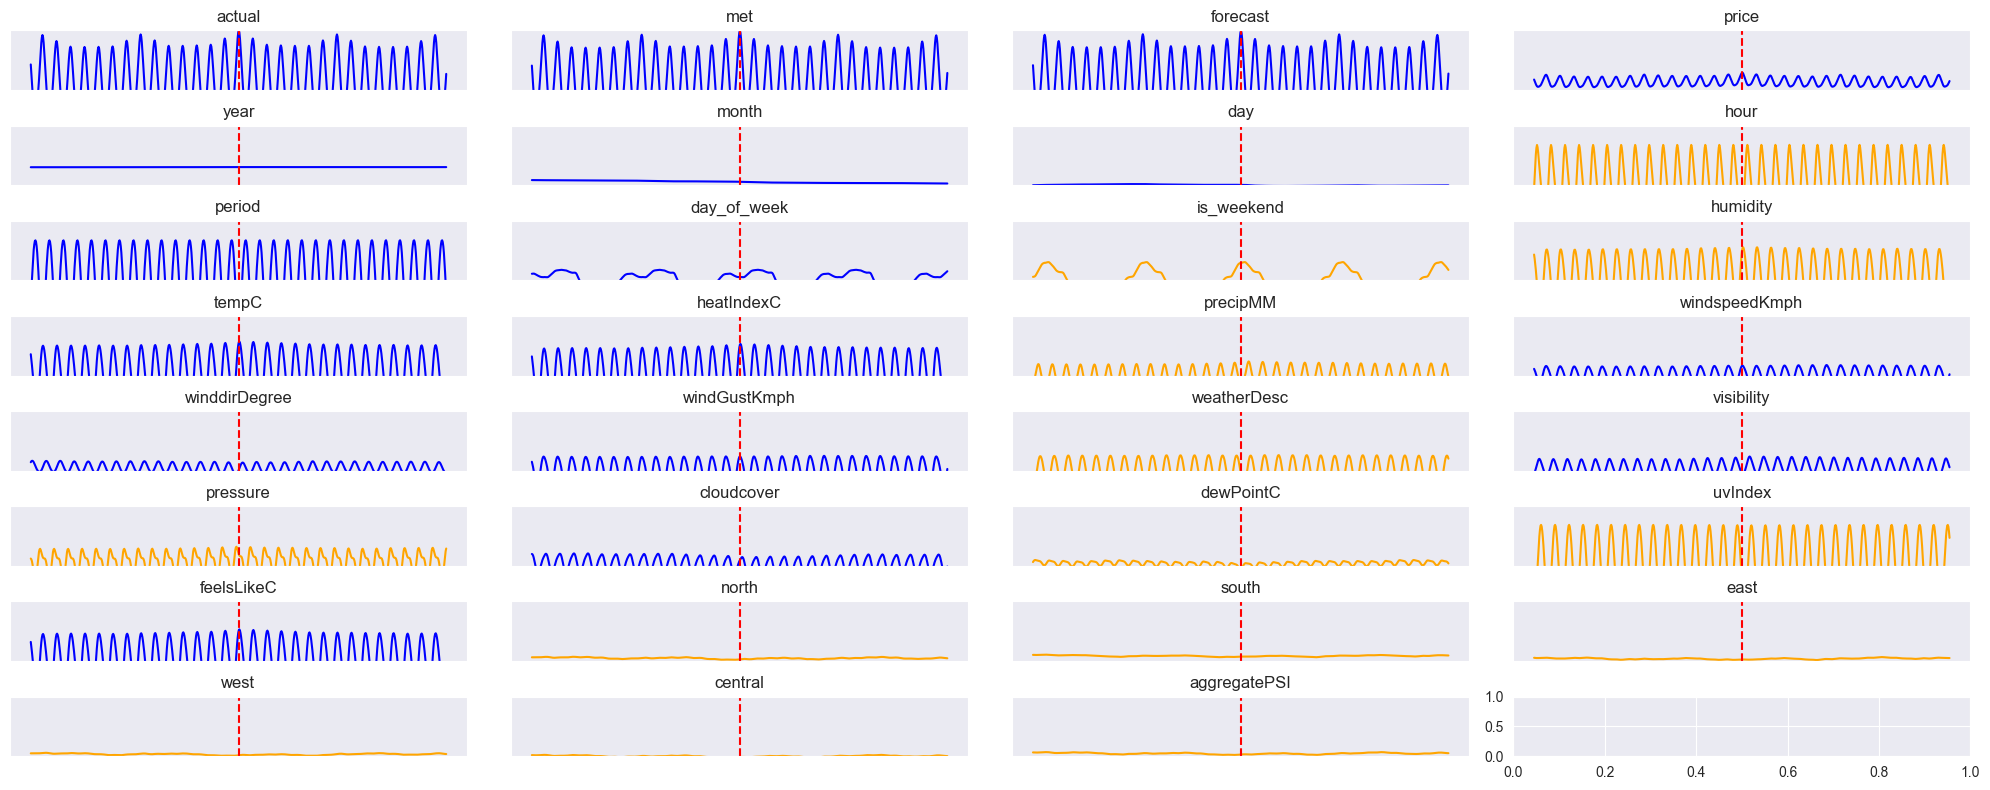

NameError: name 'fig_path' is not defined

In [122]:
fig, axes = plt.subplots(8, 4, figsize=(20, 4 * 2))
axes = axes.flatten()
# fig.suptitle(f'Lagged Feature Correlations', fontsize=16)

counter = 0

for col in data.columns:
    
    correlations = []
    # calculate and append correlation for each lag point
    for idx, lag in enumerate(time_lags):
        correlation = calculate_lag_correlation(data['actual'], data[col], lag, corr_type='pearson')
        correlations.append(correlation)
        
    has_plot = plot_lag_correlation(np.array(correlations), 'actual', col, time_lags, fig, axes, counter)
    
    if has_plot:
        counter += 1

plt.tight_layout()
plt.show()
fig.savefig(fig_path + 'lagged_correlations.png', bbox_inches='tight')

## Random Forest-Recursive Feature Elimination (RF-RFE)
For feature selection - check the weights and select from there.

In [13]:
from tqdm import tqdm 

def create_sequences(df_, input_window=512, output_window=96, step=10):
    """
    Create sequences from a DataFrame for sequence-to-sequence prediction.
    
    :param df_: pandas DataFrame with features and target
    :param input_window: number of past time steps for input
    :param output_window: number of future time steps for prediction
    :param step: step size for sliding window
    :return: X (input sequences), y (output sequences)
    """
    feature_columns = df_.columns[1:]  # Assuming the first column is the target
    target_column = df_.columns[1]
    
    X, y = [], []
    
    for i in tqdm(range(0, len(df_) - input_window - output_window + 1, step)):
        X.append(df_[feature_columns].iloc[i:i+input_window].values)
        y.append(df_[target_column].iloc[i+input_window:i+input_window+output_window].values)
    
    return np.array(X), np.array(y)

# Assuming 'df' is your DataFrame with 61365 rows and 32 columns
# The last column is assumed to be the target variable

# Create sequences
X, y = create_sequences(data, input_window=512, output_window=96)

print("X shape:", X.shape)
print("y shape:", y.shape)

# To use with most machine learning models, you might need to reshape X
# from (n_samples, 512, 31) to (n_samples, 512 * 31)
X_reshaped = X.reshape((X.shape[0], -1))
print("Reshaped X shape:", X_reshaped.shape)
# If you're using a model that expects 3D input (like LSTM), keep X as is

# If you need to reshape y to be (n_samples, 96, 1)
# y = y.reshape((y.shape[0], y.shape[1], 1))
print("Reshaped y shape:", y.shape)

100%|██████████| 6076/6076 [00:16<00:00, 375.49it/s]


X shape: (6076, 512, 30)
y shape: (6076, 96)
Reshaped X shape: (6076, 15360)
Reshaped y shape: (6076, 96)


In [14]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


random_state = 42

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=random_state)

# Create a Random Forest classifier
rf = RandomForestRegressor(n_estimators=100, random_state=random_state)

# Create the RFE object and specify the number of features to select
n_features_to_select = 50  # Adjust this based on your needs
rfe = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=0.5, verbose=True)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

Fitting estimator with 15360 features.
Fitting estimator with 7680 features.


In [15]:
for i, name in enumerate(data.columns[1:]):
    print(i, ':', name)
    
features = data.columns[1:]

0 : met
1 : forecast
2 : price
3 : year
4 : month
5 : day
6 : hour
7 : period
8 : day_of_week
9 : is_weekend
10 : humidity
11 : tempC
12 : heatIndexC
13 : precipMM
14 : windspeedKmph
15 : winddirDegree
16 : windGustKmph
17 : weatherDesc
18 : visibility
19 : pressure
20 : cloudcover
21 : dewPointC
22 : uvIndex
23 : feelsLikeC
24 : north
25 : south
26 : east
27 : west
28 : central
29 : aggregatePSI


In [16]:
importance_intermediates = rfe.intermediates_

In [17]:
%%capture cap --no-stderr
float_formatter = "{:.7f}".format
for i, intermediate in enumerate(importance_intermediates):
    keys = list(intermediate.keys())
    values = list(intermediate.values())
    sorted_value_index = np.argsort(values)[::-1] 
    sorted_dict = {f'{features[keys[i] % 30]}_{512 - keys[i] // 30}': float_formatter(values[i]) for i in sorted_value_index}
    
    print('Iteration', i)
    print(sorted_dict)
    print()

In [18]:
with open('rf-rfe_512_timesteps_results.txt', 'w') as f:
    f.write(cap.stdout)

In [15]:
# Get the selected features
selected_features = data.columns[1:][rfe.support_]

# Transform the data to include only selected features
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Train a new Random Forest model on the selected features
rf_selected = RandomForestRegressor(n_estimators=100, random_state=random_state)
rf_selected.fit(X_train_selected, y_train)

# Make predictions and evaluate the model
y_pred = rf_selected.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')

print(f"Selected features: {selected_features}")
print(f"MSE with selected features: {mse}")

# You can also print the feature ranking
feature_ranking = sorted(zip(rfe.ranking_, data.columns[1:]))
print("Feature ranking (lower number means more important):")
for rank, feature in feature_ranking:
    print(f"{feature}: {rank}")

Selected features: Index(['met', 'forecast', 'price', 'year', 'day', 'hour', 'period',
       'day_of_week', 'is_weekend', 'humidity', 'winddirDegree',
       'windGustKmph', 'cloudcover', 'uvIndex', 'west'],
      dtype='object')
MSE with selected features: [12016.27967323 14181.63574784 15812.77117285 18610.29233712
 20379.17428153 22418.39292186 22549.56339173 24377.71607335
 25471.18994427 27447.57362568 29819.5809919  31224.00905045
 32615.44439729 33790.57116363 34436.84159033 34954.46027397
 34265.51527885 34232.7293595  34879.7853734  35160.1511337
 35395.718596   35023.79588546 34792.5733782  35422.26947696
 34678.23943121 36415.63893976 35718.51706831 36219.44953988
 36386.98575461 35572.23303095 33811.95396797 34516.18521504
 34799.85718324 36253.56216813 37365.30389263 36903.69337495
 36836.30880577 37550.71124096 38126.26841842 40138.587969
 40329.81498196 40671.65659399 39871.77723227 41411.77301862
 40959.96526417 41119.62217139 40567.62792165 40978.60829023
 41416.19698